In [54]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
import functools
from IPython.display import clear_output
import datetime as dt
import random
import itertools
from salishsea_tools import geo_tools, geo_tools, tidetools, data_tools

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [32]:
# converts lons/lats like this "124° 01.400" to decimal format
def strLonLatToDec(lstr):
    if type(lstr) is not str:
        return(np.NaN)
    lstr = lstr.replace(u'°',' ')
    lstr = lstr.split()
    return (int(lstr[0])+float(lstr[1])/60.0)

In [33]:
# Grab tracer data

#  '/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPedit.xls'
tracer_df = pd.read_excel('/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPeditfinal.xls')
tracer_df = tracer_df[~pd.isnull(tracer_df["Date"])]
#tracer_df["Date"] = pd.to_datetime(tracer_df["Date"])
tracer_df = tracer_df.sort_values("Date")
tracer_df["DECIMAL_LON"] = (tracer_df["Longitude"].apply(strLonLatToDec))*(-1)
tracer_df["DECIMAL_LAT"] = (tracer_df["Latitude"].apply(strLonLatToDec))
tracer_df["STATION_LAT"] =  tracer_df.groupby("Station ID")["DECIMAL_LAT"].transform(np.median)
tracer_df["STATION_LON"] =  tracer_df.groupby("Station ID")["DECIMAL_LON"].transform(np.median)

In [34]:
# Create smaller dataframe with location of stations
station_lon_lat = tracer_df[["Station ID", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])

In [35]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd

mat = loadmat('/ocean/jylam/Final/2015/PSF_CWBstn.mat')  # load mat-file
mdata = mat['PSFc']  # variable in mat file

ndata = {n: mdata[n][0, 0] for n in mdata.dtype.names}

for key in ndata.keys():
    if ndata[key].shape == (400, 2054):
        ndata[key] = ndata[key].ravel()
    elif ndata[key].shape == (1, 2054):
        ndata[key] = np.tile(ndata[key],400).ravel()
    else:
        print("what")
all_ts_df = pd.DataFrame(ndata)

In [38]:
patrol_num_name = {1 : "LD", 2 : "PR", 3 : "IS", 4 : "BS", 5 : "NQ", 6 : "CR", 8 : "SV", 9 : "VC", 10 : "CWB"}
def get_station_name(patrol_num, station_num):
    station_name = None
    patrol_name = patrol_num_name[patrol_num]
    if patrol_name == "CWB":
        if station_num == 5:
           station_name = "CBW2"
        elif station_num ==7:
           station_name = "CBC1"
        elif station_num ==8:
           station_name = "CBC2"
        elif station_num ==9: 
           station_name = "CBC3"
        elif station_num ==11:
           station_name = "CBE2"
    else:
        station_name = patrol_name + str(station_num)
    return(station_name)

all_ts_df["STATION_NAME"] = all_ts_df.apply(lambda row: get_station_name(int(row["patrol"]), int(row["stnN"])), axis = 1)
all_ts_df = all_ts_df[~pd.isnull(all_ts_df["mtimes"])]
all_ts_df["DATE"] = all_ts_df.mtimes.apply(lambda mt: dt.datetime.fromordinal(int(mt)) + dt.timedelta(days=mt%1) - dt.timedelta(days = 366))

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
ts_df = all_ts_df[["STATION_NAME", "DATE","long", "lat", "depth", "sal", "temp"]]
ts_df.columns = ["STATION", "DATE", "LON", "LAT", "DEPTH", "SAL", "TEMP"]
ts_df["DATA_TYPE"] = "Measured"
ts_df["DAY_OF_YEAR"] = ts_df["DATE"].apply(lambda x: x.dayofyear)

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
# Choose which values to add to nowcast dataframe

tracers = ["votemper", "vosaline"]

months = ["feb", "mar", "apr", "may", "jun", "jul", "aug", "sep"]

hours = np.array([12])

max_depth = 60
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

station_points = station_lon_lat["MODEL_POINT"]
station_names = station_lon_lat["STATION"]

stations = dict(zip(station_names, station_points))

nowcast_df = pd.read_pickle("/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/station_ts_feb-sep.pkl")
#nowcast_df["DATE"] = pd.to_datetime(nowcast_df["DATE"], infer_datetime_format=True)
#nowcast_df = data_tools.load_nowcast_station_tracers(tracers, stations, months, hours, depth_indices, file_ending = "grid_T.nc", save_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/station_ts_feb-sep.pkl")

Files loaded:1
Date of most recent nowcast load: 20160201
Time loading: 
0:00:33.368343
Files loaded:2
Date of most recent nowcast load: 20160202
Time loading: 
0:00:45.306132
Files loaded:3
Date of most recent nowcast load: 20160203
Time loading: 
0:00:54.751138
Files loaded:4
Date of most recent nowcast load: 20160204
Time loading: 
0:01:04.035755
Files loaded:5
Date of most recent nowcast load: 20160205
Time loading: 
0:01:13.087962
Files loaded:6
Date of most recent nowcast load: 20160206
Time loading: 
0:01:22.008981
Files loaded:7
Date of most recent nowcast load: 20160207
Time loading: 
0:01:30.284690
Files loaded:8
Date of most recent nowcast load: 20160208
Time loading: 
0:01:38.548705
Files loaded:9
Date of most recent nowcast load: 20160209
Time loading: 
0:01:46.771252
Files loaded:10
Date of most recent nowcast load: 20160210
Time loading: 
0:01:55.164683
Files loaded:11
Date of most recent nowcast load: 20160211
Time loading: 
0:02:03.800103
Files loaded:12
Date of most r

In [49]:
nowcast_df["SALINITY"] = nowcast_df["vosaline"]
nowcast_df["TEMPERATURE"] = nowcast_df["votemper"]
ts_df["SALINITY"] = ts_df["SAL"]
ts_df["TEMPERATURE"] = ts_df["TEMP"]

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
np.unique(ts_df.DEPTH)

array([   0.25,    0.75,    1.25,    1.75,    2.25,    2.75,    3.25,
          3.75,    4.25,    4.75,    5.25,    5.75,    6.25,    6.75,
          7.25,    7.75,    8.25,    8.75,    9.25,    9.75,   10.25,
         10.75,   11.25,   11.75,   12.25,   12.75,   13.25,   13.75,
         14.25,   14.75,   15.25,   15.75,   16.25,   16.75,   17.25,
         17.75,   18.25,   18.75,   19.25,   19.75,   20.25,   20.75,
         21.25,   21.75,   22.25,   22.75,   23.25,   23.75,   24.25,
         24.75,   25.25,   25.75,   26.25,   26.75,   27.25,   27.75,
         28.25,   28.75,   29.25,   29.75,   30.25,   30.75,   31.25,
         31.75,   32.25,   32.75,   33.25,   33.75,   34.25,   34.75,
         35.25,   35.75,   36.25,   36.75,   37.25,   37.75,   38.25,
         38.75,   39.25,   39.75,   40.25,   40.75,   41.25,   41.75,
         42.25,   42.75,   43.25,   43.75,   44.25,   44.75,   45.25,
         45.75,   46.25,   46.75,   47.25,   47.75,   48.25,   48.75,
         49.25,   49

In [60]:
nowcast_df["DAY_OF_YEAR"] = nowcast_df["DATE"].apply(lambda x: x.dayofyear)
nowcast_df["DATA_TYPE"] = "Nowcast"
combined = pd.concat([ts_df.query("(DEPTH - 0.75)**2 < 0.0001 | (DEPTH - 19.75)**2 < 0.0001"), nowcast_df.query("(DEPTH - 0.500011)**2 < 0.0001 | (DEPTH - 19.481785)**2 < 0.0001")])
combined["IDENTIFIER"] = combined["DATA_TYPE"] + ", Depth = " + combined["DEPTH"].apply(str)
combined.STATION = combined.STATION.apply(lambda x: x.strip() if x is not None else x)
combined = combined.sort_values(["STATION", "DATE"])

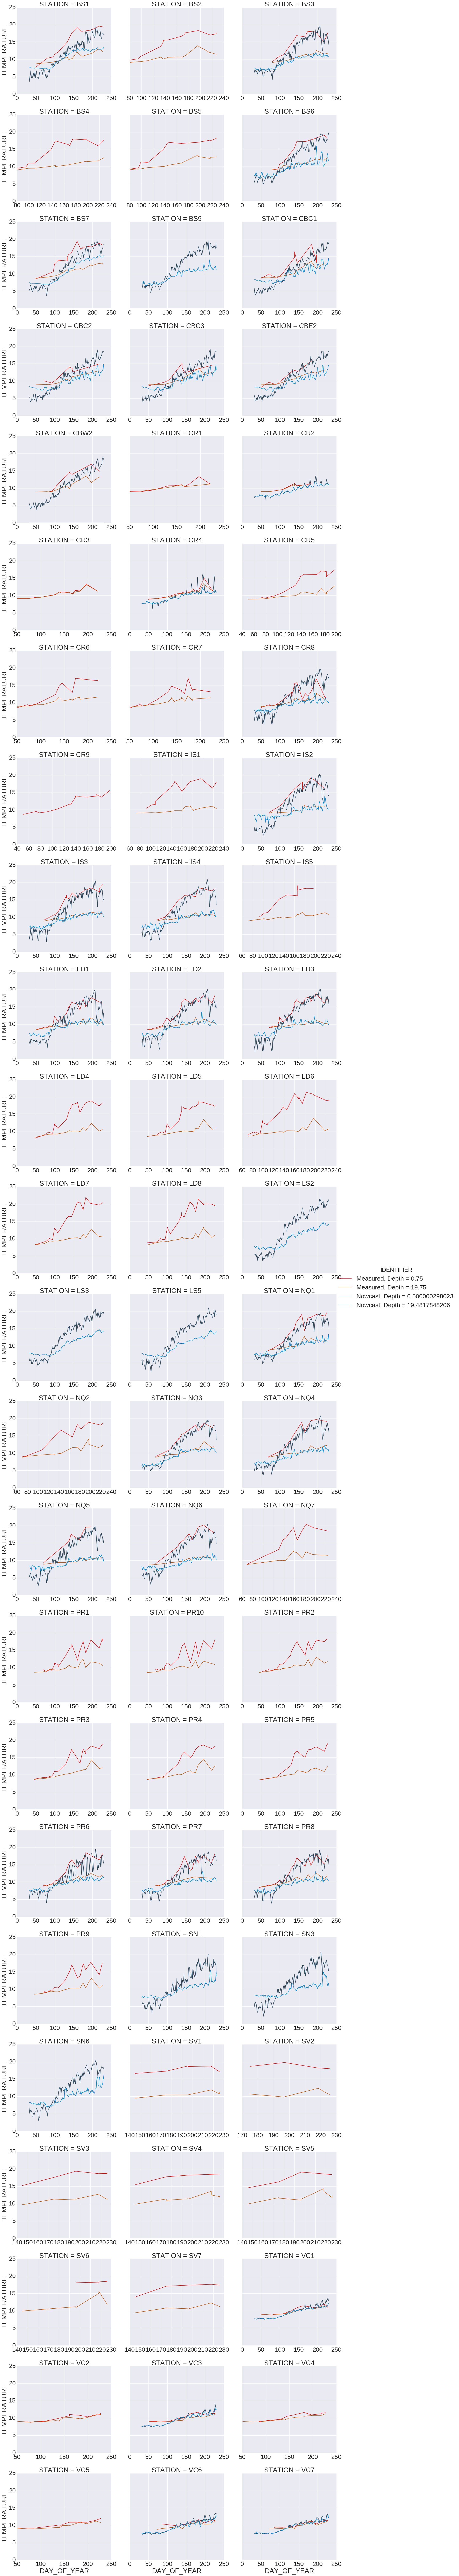

In [61]:
# Temperature

colors = ["red","burnt orange", "dark grey blue", "cerulean",]
cmap = sns.xkcd_palette(colors)

sns.set(font_scale = 3)
fg = sns.FacetGrid(data = combined[(combined["DAY_OF_YEAR"] <= max(nowcast_df["DAY_OF_YEAR"]))], col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = False, sharey = True, palette= cmap)
fg.map(plt.plot,"DAY_OF_YEAR", "TEMPERATURE").add_legend()
#plt.xticks(rotation=45)
plt.subplots_adjust(top=0.9)

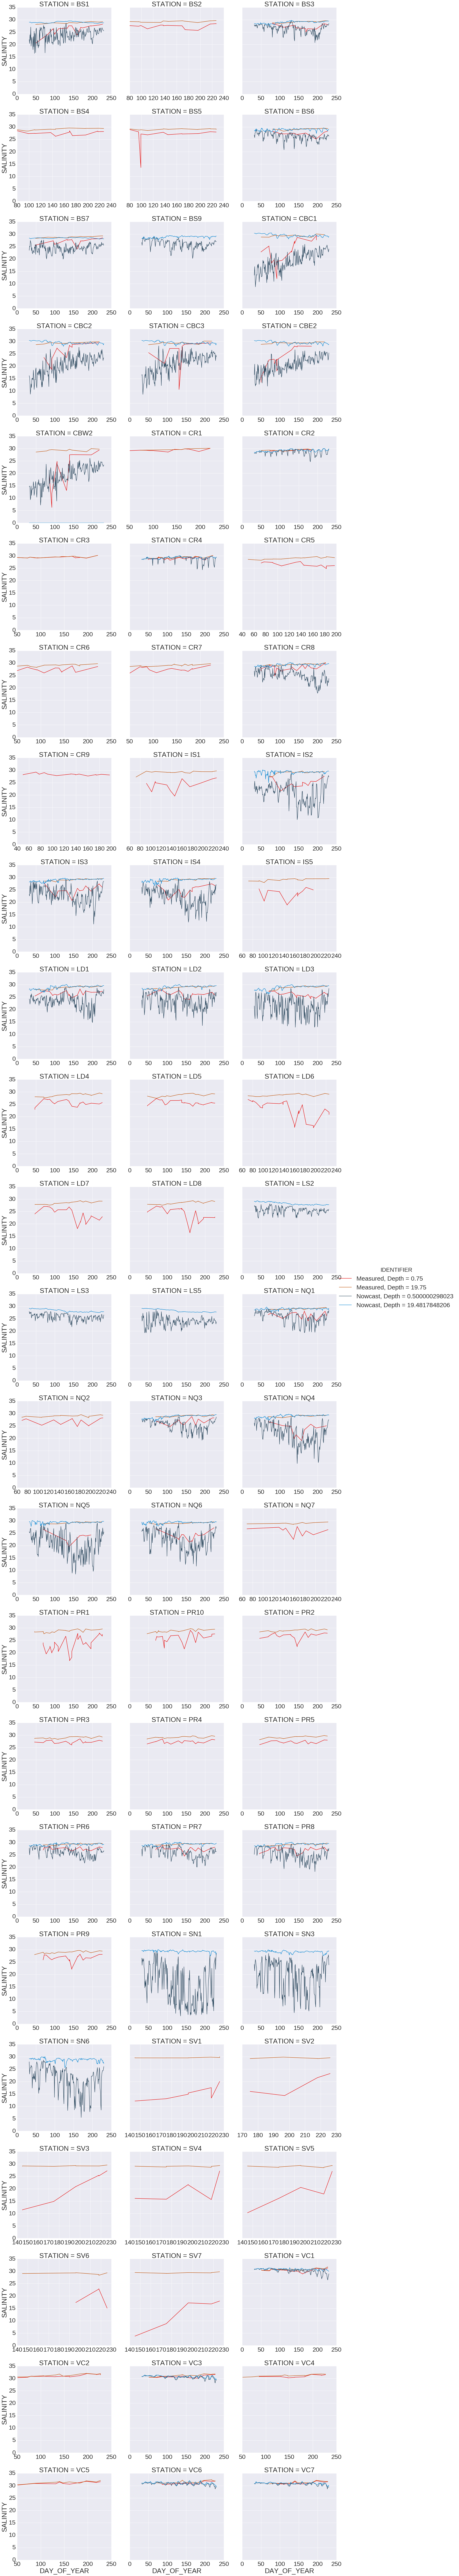

In [62]:
#Salinity

colors = ["red","burnt orange", "dark grey blue", "cerulean",]
cmap = sns.xkcd_palette(colors)

sns.set(font_scale = 3)
fg = sns.FacetGrid(data = combined[(combined["DAY_OF_YEAR"] <= max(nowcast_df["DAY_OF_YEAR"]))], col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = False, sharey = True, palette= cmap)
fg.map(plt.plot,"DAY_OF_YEAR", "SALINITY").add_legend()
#plt.xticks(rotation=45)
plt.subplots_adjust(top=0.9)